### Imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
print(torch.__version__)

2.0.0


### Data Download and Data arrangement

->>>>> to download the data follow jovian cnn notebook

In [3]:
### To create a dataset from folder
from torchvision.datasets import ImageFolder
import os

In [4]:
data_dir = "../Jovian/data/cifar10"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


In [5]:
train_ds = ImageFolder(data_dir +'/train', transform=ToTensor())
len(train_ds)

50000

In [6]:
test_ds = ImageFolder(root = data_dir+"/test", transform = ToTensor())
len(test_ds)

10000

In [7]:
## Split the train data to train and validation set
train_ds, valid_ds = random_split(train_ds, [40000, 10000])
len(train_ds), len(valid_ds)

(40000, 10000)

In [8]:
img, label = train_ds[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 5


tensor([[[0.5608, 0.5647, 0.5569,  ..., 0.5059, 0.5373, 0.6196],
         [0.5294, 0.5451, 0.5686,  ..., 0.5490, 0.5882, 0.6235],
         [0.5451, 0.5529, 0.5686,  ..., 0.6118, 0.6078, 0.6235],
         ...,
         [0.5804, 0.5804, 0.5882,  ..., 0.5765, 0.5647, 0.5647],
         [0.5843, 0.5765, 0.5882,  ..., 0.5765, 0.5647, 0.5647],
         [0.5725, 0.5843, 0.5765,  ..., 0.5686, 0.5686, 0.5608]],

        [[0.3882, 0.4039, 0.3961,  ..., 0.2824, 0.3373, 0.4078],
         [0.3529, 0.3804, 0.4078,  ..., 0.3137, 0.3922, 0.4196],
         [0.3647, 0.3804, 0.4039,  ..., 0.3804, 0.3961, 0.4196],
         ...,
         [0.3922, 0.4000, 0.4196,  ..., 0.4471, 0.4353, 0.4275],
         [0.4118, 0.4039, 0.4157,  ..., 0.4510, 0.4431, 0.4431],
         [0.4039, 0.4118, 0.4039,  ..., 0.4392, 0.4510, 0.4431]],

        [[0.1725, 0.1961, 0.1922,  ..., 0.0353, 0.0667, 0.1176],
         [0.1294, 0.1647, 0.2000,  ..., 0.0588, 0.0824, 0.1137],
         [0.1255, 0.1490, 0.1804,  ..., 0.0784, 0.0902, 0.

In [9]:
print(train_ds.dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
def show_example(img, label):
    print(f"Label: {train_ds.dataset.classes[label]} -> ({str(label)})")
    plt.imshow(img.permute(1,2,0))
    plt.axis(False)

Label: dog -> (5)


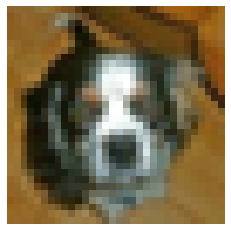

In [11]:
show_example(*train_ds[0])

Label: truck -> (9)


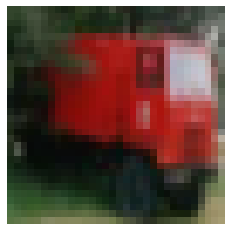

In [12]:
show_example(*train_ds[100])

### Data to Dataloader

In [13]:
## dataloader
batch_size = 128
train_dl = DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(dataset = valid_ds, batch_size = batch_size*2)
test_dl = DataLoader(dataset = test_ds, batch_size = batch_size*2)

In [14]:
for image, label in train_dl:
    print(f"image shape: {image.shape}")
    print(f"label shape: {label.shape}")
    break

image shape: torch.Size([128, 3, 32, 32])
label shape: torch.Size([128])


In [15]:
for image, label in valid_dl:
    print(f"image shape: {image.shape}")
    print(f"label shape: {label.shape}")
    break

image shape: torch.Size([256, 3, 32, 32])
label shape: torch.Size([256])


### Data Visualization

In [16]:
from torchvision.utils import make_grid

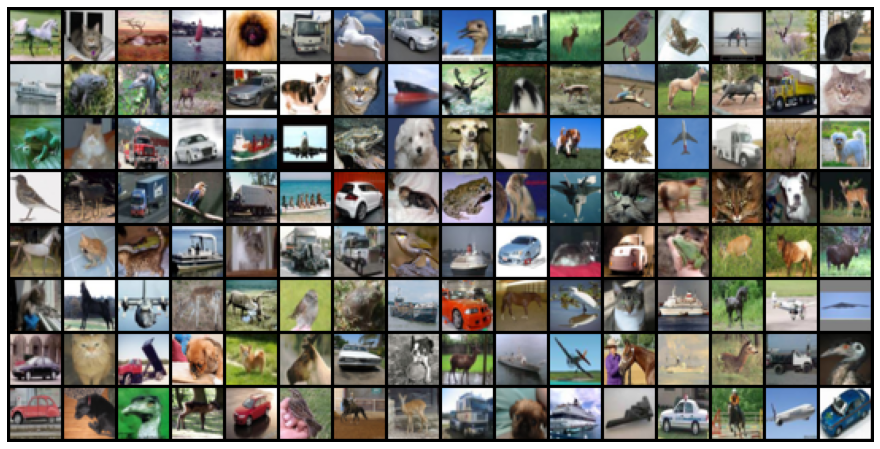

In [17]:
for image, label in train_dl:
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(image, nrow=16).permute(1,2,0))
    break

### Function for device and devicedataloader

In [18]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

In [19]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return len(self.dl)

### Swithching data to device

In [21]:
device = get_device()
device

device(type='mps')

In [22]:
### moving the dataloaders to device
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(valid_dl, device)
test_loader = DeviceDataLoader(test_dl, device)

In [23]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb.device:', yb.device)
    break

xb.device: mps:0
yb.device: mps:0


In [24]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            model.train()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        model.eval()
        with torch.inference_mode():
            result = evaluate(model, val_loader)
            model.epoch_end(epoch, result)
            history.append(result)
    return history

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [49]:
class CIFAR10Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # layer 1
        self.linear1 = nn.Linear(in_size, 64)
        # layer 2
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 128)
        # layer 3
        self.linear4 = nn.Linear(128, out_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = self.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)        
        # Apply activation function
        out = self.relu(out)
        # Get predictions using output layer
        out = self.linear3(out) 
        # Apply activation function
        out = self.relu(out)
        # Get predictions using output layer
        out = self.linear4(out) 
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [50]:
input_size = 3*32*32
num_classes = 10

In [51]:
model = CIFAR10Model(input_size, num_classes)
to_device(model, device)

CIFAR10Model(
  (linear1): Linear(in_features=3072, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [52]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 3072])
torch.Size([64])
torch.Size([128, 64])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [53]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3010308742523193
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0381,  0.1015, -0.0622,  0.0203, -0.0115,  0.0148, -0.0040, -0.0761,
         -0.0402,  0.0063],
        [-0.0431,  0.0868, -0.0756,  0.0212,  0.0050,  0.0207, -0.0129, -0.0765,
         -0.0233,  0.0133]], device='mps:0')


In [54]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3033223152160645, 'val_acc': 0.10332031548023224}]

In [55]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2722, val_acc: 0.1271
Epoch [1], val_loss: 2.1337, val_acc: 0.2069
Epoch [2], val_loss: 2.0281, val_acc: 0.2549
Epoch [3], val_loss: 1.9679, val_acc: 0.2812
Epoch [4], val_loss: 1.9284, val_acc: 0.3010


In [56]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9065, val_acc: 0.3087
Epoch [1], val_loss: 1.8670, val_acc: 0.3188
Epoch [2], val_loss: 1.8695, val_acc: 0.3267
Epoch [3], val_loss: 1.8065, val_acc: 0.3525
Epoch [4], val_loss: 1.8148, val_acc: 0.3479


In [57]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7719, val_acc: 0.3625
Epoch [1], val_loss: 1.7719, val_acc: 0.3660
Epoch [2], val_loss: 1.7247, val_acc: 0.3840
Epoch [3], val_loss: 1.7421, val_acc: 0.3794
Epoch [4], val_loss: 1.7422, val_acc: 0.3746


In [58]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.8681, val_acc: 0.3362
Epoch [1], val_loss: 1.7171, val_acc: 0.3873
Epoch [2], val_loss: 1.7008, val_acc: 0.3887
Epoch [3], val_loss: 1.6301, val_acc: 0.4188
Epoch [4], val_loss: 1.6097, val_acc: 0.4241


In [59]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5808, val_acc: 0.4315
Epoch [1], val_loss: 1.5795, val_acc: 0.4294
Epoch [2], val_loss: 1.5603, val_acc: 0.4427
Epoch [3], val_loss: 1.5142, val_acc: 0.4571
Epoch [4], val_loss: 1.6419, val_acc: 0.4194
Epoch [5], val_loss: 1.4752, val_acc: 0.4730
Epoch [6], val_loss: 1.4874, val_acc: 0.4690
Epoch [7], val_loss: 1.5687, val_acc: 0.4391
Epoch [8], val_loss: 1.4538, val_acc: 0.4805
Epoch [9], val_loss: 1.4464, val_acc: 0.4771


In [60]:
history += fit(5, 0.09, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5586, val_acc: 0.4438
Epoch [1], val_loss: 1.6857, val_acc: 0.4052
Epoch [2], val_loss: 1.5507, val_acc: 0.4499
Epoch [3], val_loss: 1.5639, val_acc: 0.4296
Epoch [4], val_loss: 1.5586, val_acc: 0.4394
